In [ ]:
#default_exp storage

# Storage 

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

Macro-X-Ray-Fluorescence (MA-XRF) data typically do not fit into memory. In order to make optimal use of your computer memory and processors it is therefore necessary to convert such spectral data into a chunked analysis-ready file format. The `maxrf4u` package makes use of a specially developed `.datastack` file format. This format is based on [zarr](https://zarr.readthedocs.io/en/stable/) ZipStore. 

### Creating a .datastack file to do out-of-memory calculations 

In this example below we show how to convert a MA-XRF dataset  consisting of a `.raw` data cube file (and an `.rpl` shape file) into a `.datastack` file. On my laptop this initial conversion of a 21 Gb dataset takes 7:11 minutes.... 

In [ ]:
cd '/home/frank/Work/Projecten/DoRe/viz/raw_nmf' 

/mnt/datadisk/Work/Projecten/DoRe/viz/raw_nmf


In [ ]:
!ls -lh

total 46G
-rw-rw-r-- 1 frank frank 26G feb  1 21:11 RP-T-1898-A-3689.datastack
-rwxrwxrwx 1 frank frank 21G mrt  9  2021 RP-T-1898-A-3689.raw
-rwxrwxrwx 1 frank frank 181 mrt  9  2021 RP-T-1898-A-3689.rpl


In [ ]:
import maxrf4u

In [ ]:
maxrf4u.raw_to_datastack('RP-T-1898-A-3689.raw', 'RP-T-1898-A-3689.rpl')

Writing: RP-T-1898-A-3689.datastack...
[########################################] | 100% Completed |  4min 32.7s
Computing max and sum spectra...
Computing max spectrum...
[########################################] | 100% Completed |  1min 17.0s
Computing sum spectrum...
[########################################] | 100% Completed |  1min 17.1s


It is now possible to check the content (i.e. the datasets) of the .datastack file with the `tree()` function. 

In [ ]:
maxrf4u.tree('RP-T-1898-A-3689.datastack')

RP-T-1898-A-3689.datastack:

/
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


With the `show_arrays=True` option the `tree()` function also shows the shapes of the individual datasets. 

In [ ]:
maxrf4u.tree('RP-T-1898-A-3689.datastack', show_arrays=True)

RP-T-1898-A-3689.datastack:

/
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


With the freshly created `.datastack` file it is now possible to explore and process the data. Let's start this exploration by plotting numpy arrays that are returned by the `max_spectrum()` and `sum_spectrum()` convenience methods. The max and sum spectra provide a good summary of the spectral data. The horizontal axis shows the detector channel numbers. Note that inconveniently the data does not provide an energy calibration. 

In [ ]:
ds = maxrf4u.DataStack('RP-T-1898-A-3689.datastack', verbose=True)

RP-T-1898-A-3689.datastack:

/
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


<IPython.core.display.Javascript object>


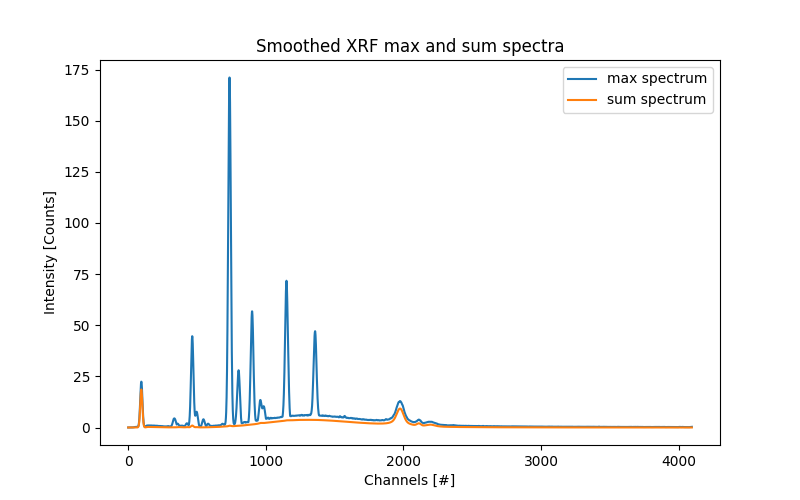

In [ ]:
import matplotlib.pyplot as plt 

y_max = ds.read_maxspectrum()
y_sum = ds.read_sumspectrum()

fig, ax = plt.subplots(figsize=[8, 5])
ax.plot(y_max, label='max spectrum')
ax.plot(y_sum, label='sum spectrum')
ax.set_title('Smoothed XRF max and sum spectra')
ax.set_xlabel('Channels [#]')
ax.set_ylabel('Intensity [Counts]')
ax.legend();

### `maxrf4u.storage.py` 

In [ ]:
#export 

import maxrf4u

import numpy as np 
import dask 
import dask.array as da 
from dask.diagnostics import ProgressBar 
import dask_ndfilters 
import re 
import os 
import zarr 
from IPython.display import HTML 
import cv2
import matplotlib.pyplot as plt 
import scipy.signal as ssg 
import time 


# CONSTANTS 
DATASTACK_EXT = '.datastack' 

# datastack layer one 
MAXRF_CUBE = 'maxrf_cube'
MAXRF_MAXSPECTRUM = 'maxrf_maxspectrum'
MAXRF_SUMSPECTRUM = 'maxrf_sumspectrum'
MAXRF_ENERGIES = 'maxrf_energies'

# datastack layer two  
HOTMAX_SPECTRA = 'hotmax_spectra'
HOTMAX_PIXELS = 'hotmax_pixels' 
HOTMAX_INTENSITIES = 'hotmax_intensities'

# datastack layer three 
MAPS_IMVIS = 'maps_imvis'


# functions 

def raw_to_datastack(raw_file, rpl_file, datastack_file=None, datapath=MAXRF_CUBE, verbose=True): 
    '''Convert Bruker Macro XRF (.raw) data file *raw_filename* and (.rpl) shape file *rpl_filename*.  
    
    into a Zarr Zipstore datastack file (.datastack).'''
    
    # generate datastack filename from .raw 
    if datastack_file is None: 
        datastack_file = re.sub('\.raw$', DATASTACK_EXT, raw_file) 
        
    # read data cube shape from .rpl file 
    with open(rpl_file, 'r') as fh: 
        lines = fh.readlines()

    # get rid of spaces and newline characters 
    keys_and_values = dict([re.sub(' |\n', '', l).split('\t') for l in lines]) 

    width = int(keys_and_values['width'])
    height = int(keys_and_values['height'])
    depth = int(keys_and_values['depth'])

    shape = (height, width, depth)
    
    # create numpy memory map 
    raw_mm = np.memmap(raw_file, dtype='uint16', mode='r', shape=(height, width, depth))[::-1, ::-1] 

    # initializing dask array 
    arr = da.from_array(raw_mm) 
    arr = arr.astype(np.float32)

    # schedule spectral gaussian smoothing computation 
    smoothed = dask_ndfilters.gaussian_filter(arr, (0, 0, 7)) 

    # create and open an empty zip file
    zs = zarr.ZipStore(datastack_file, mode='w') 
    
    if verbose: 
        print(f'Writing: {datastack_file}...')

    # compute and write maxrf data to zipstore 
    with ProgressBar(): 
        smoothed.to_zarr(zs, component=datapath) 
        
    zs.close()
    
    # compute sum and max spectra and append to zipstore 
    
    print('Computing max and sum spectra...')
    
    y_max, y_sum = max_and_sum_spectra(datastack_file, datapath=MAXRF_CUBE)
    
    append(y_max, MAXRF_MAXSPECTRUM, datastack_file)
    append(y_sum, MAXRF_SUMSPECTRUM, datastack_file)
    
    

def tree(datastack_file, show_arrays=False): 
    '''Prints content tree of *datastack_file* '''

    with zarr.ZipStore(datastack_file, mode='r') as zs: 
        root = zarr.group(store=zs) 
        tree = root.tree(expand=True).__repr__()
        print(f'{datastack_file}:\n\n{tree}')  
        
        if show_arrays:        
            datasets = sorted(root)
            arrays_html = ''

            for ds in datasets: 
                arr = da.from_array(root[ds])
                html = arr._repr_html_()
                arrays_html = f'{arrays_html}- Dataset: <h style="color:brown">{ds}</h>{html}' 
   
            return HTML(arrays_html)

def underscorify(datapath, datapath_list, extra_underscore=True): 
    '''Append extra underscore if *datapath* exists to prevent overwriting. 
    
    If *extra_underscore=False* return (latest) datapath with most underscores'''
    
    if datapath in datapath_list: 
        r = re.compile(f'{datapath}_*$')
        datapath = sorted(filter(r.match, datapath_list))[-1]
        
        if extra_underscore: 
            datapath = datapath + '_'
        
    return datapath 


def append(arr, datapath, datastack_file): 
    '''Add numpy or dask array *arr* to *datastack_file* in folder *datapath*.'''
    
    if not isinstance(arr, dask.array.Array):  
        arr = da.from_array(arr) 
            
    with zarr.ZipStore(datastack_file, mode='a') as zs: 
        root = zarr.group(store=zs)
        
        # append underscores to make unique if datapath exists 
        datapath_list = sorted(root) 
        datapath = underscorify(datapath, datapath_list)
        
        # write      
        arr.to_zarr(zs, component=datapath)



def repack(datastack_file, select='all', overwrite=True, verbose=False): 
    '''Repack *datastack_file* by deleting and renaming all but latest datasets. 
    
    Automatic selection of latest datasets can be overriden be providing list of *select* datasets''' 
    
    if verbose: 
        tree(datastack_file)
    
    # open existing zipstore  
    zs = zarr.ZipStore(datastack_file, mode='r') 
    root = zarr.group(store=zs)
    datapath_list = sorted(root)  
    
    # select newest version (most underscores) for all datasets
    if select is 'all': 
        selected = sorted(set([underscorify(dp, datapath_list, extra_underscore=False) for dp in datapath_list])) 
    # select newest version (most underscores) for datasets in select
    else: 
        selected = sorted(set([underscorify(dp, datapath_list, extra_underscore=False) for dp in select]))       
    
    # remove underscores 
    renamed = [re.sub('_*$', '', s) for s in selected] 
    
    # create and open new empty zipstore 
    datastack_file_new = datastack_file + '_temp'
    zs_new = zarr.ZipStore(datastack_file_new, mode='w') 
    
    # copy selected datasets into new zipstore 
    with ProgressBar(): 
        for src, dst in zip(selected, renamed): 
            print(f'Repacking dataset: \'{src}\'') 
            arr = da.from_array(root[src])
            arr.to_zarr(zs_new, component=dst)
    
    zs.close()
    zs_new.close()
    
    # finally overwrite old with new  
    if overwrite: 
        os.replace(datastack_file_new, datastack_file)
    
    if verbose:
        print()
        tree(datastack_file)
        

def max_and_sum_spectra(datastack_file, datapath=MAXRF_CUBE): 
    '''Compute sum spectrum and max spectrum for 'maxrf' dataset in *datastack_file*. 
    
    Returns: *y_sum*, *y_max*'''
    
    # open existing zipstore  
    zs = zarr.ZipStore(datastack_file, mode='r') 
    root = zarr.group(store=zs)
    
    # initialize dask array 
    arr = da.from_array(root[datapath])
        
    # flatten
    h, w, d = arr.shape
    arr_flat = arr.reshape([h*w, d]) 
    
    # schedule computations 
    sum_spectrum = arr_flat.sum(axis=0)
    max_spectrum = arr_flat.max(axis=0)
    
    # compute 
    print('Computing max spectrum...')
    with ProgressBar():
        y_max = max_spectrum.compute() 
    print('Computing sum spectrum...')
    with ProgressBar(): 
        y_sum = sum_spectrum.compute() / (h * w)
        
    zs.close()
     
    return y_max, y_sum 


        
class DataStack: 
    
    def __init__(self, datastack_file, mode='r', verbose=False, show_arrays=True): 
        '''Initialize DataStack object from *datastack_file*.'''
        
        self.mode = mode 
        self.datastack_file = datastack_file 
        
        self.update_attrs()
            
        # print tree 
        if verbose: 
            tree(self.datastack_file, show_arrays=show_arrays) 
            
    def update_attrs(self): 
        
        # populate store attributes 
        self.store = zarr.ZipStore(self.datastack_file, mode=self.mode) 
        self.root = zarr.group(store=self.store) 
        
        # generic exposure to dask arrays 
        self.datapath_list = sorted(self.root) 
        self.datasets = {dp: da.from_array(self.root[dp]) for dp in self.datapath_list}
        
        # attributify dask arrays 
        # useful for code development, perhaps confusing for users 
        # might turn off this feature later 
        for dp, ds in self.datasets.items(): 
            setattr(self, dp, ds) 
        
            
    def latest(self, datapath): 
        '''Return latest version of datapath. '''
        
        datapath = underscorify(datapath, self.datapath_list, extra_underscore=False)
        
        return datapath 
        
            
    def read(self, datapath, latest=True, compute=True):
        '''Read latest version of dataset for *datapath*
        
        Returns numpy array if dataset exists. Otherwise returns None. '''
        
        if datapath in self.datapath_list: 
            if latest: 
                datapath = self.latest(datapath)     
            dataset = self.datasets[datapath] 
            if compute: 
                dataset = dataset.compute()
        else: 
            dataset = None 
    
        return dataset

    
    def tree(self, show_arrays=False): 
        '''Prints content tree of datastack.'''
        
        tree(self.datastack_file, show_arrays=show_arrays)
            
                    
    def read_maxspectrum(self): 
        '''Convenience method. Returns latest numpy array of max spectrum dataset. '''
        
        dataset = self.read(MAXRF_MAXSPECTRUM) 
        
        return dataset
        
    
    def read_sumspectrum(self): 
        '''Convenience method. Returns numpy array of sum spectrum dataset. '''
        
        dataset = self.read(MAXRF_SUMSPECTRUM) 
        
        return dataset
        

    def read_energies(self): 
        '''Convenience method. Returns latest numpy array of channel energies (in keV units).
        
        If not yet available from datastack, calibrate, inspect and save. '''
        
        x_keVs = self.read(MAXRF_ENERGIES) 
        
        
        if x_keVs is None: 
            print('This datastack does not contain a required channel energy calibration.')
            print('Please calibrate now.')
        
            x_keVs = maxrf4u.calibrate(self.datastack_file)
                
            # update attributes 
            self.update_attrs()
             
        return x_keVs
    
    def read_hotmax(self, prominence=0.35):  
        '''Convenience method. Returns numpy arrays of hotmax pixels and corresponding hotmax spectra. 
        
        If available from datastack file, otherwise, calibrate, inspect and save. '''
        
        hotmax_pixels = self.read(HOTMAX_PIXELS) 
        hotmax_spectra = self.read(HOTMAX_SPECTRA) 
    
        if (hotmax_spectra is None) or (hotmax_pixels is None): 
            
            print('Datastack file does not yet contain required hotmax data layer.')
            print('Locating hotmax pixels and spectra now: ')
             
            hotmax_pixels, hotmax_spectra  = maxrf4u.get_hotmax(self.datastack_file, prominence=prominence) 
            
            # update attributes 
            self.update_attrs()

        return hotmax_pixels, hotmax_spectra 
             
                
    def close(self): 
        '''Close file handle'''
         
        self.store.close()
        self.mode = 'closed' 
        
        print(f'Closed: {self.datastack_file}') 
        

Overwriting /home/frank/Work/Projecten/DoRe/code/maxrf4u/storage.py
